<a href="https://colab.research.google.com/github/pranathibinf/Guide_Seq/blob/main/LRRK2_guide_seq_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
# Set up everything on drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
# Creating workspace
import os
result_dir = '/content/drive/MyDrive/guideseq_results'
os.makedirs(result_dir, exist_ok=True)

In [15]:
import os
import zipfile
import shutil

# Set up working and result directories
work_dir = '/content/guideseq'
result_dir = '/content/drive/MyDrive/guideseq_results'
os.makedirs(work_dir, exist_ok=True)
os.makedirs(result_dir, exist_ok=True)

# Step 1: Download the Zenodo ZIP archive (data access)
!wget -O /content/guideseq_data.zip https://zenodo.org/api/records/10800918/files-archive

# Step 2: Unzip the downloaded file
with zipfile.ZipFile('/content/guideseq_data.zip', 'r') as zip_ref:
    zip_ref.extractall(work_dir)

# Step 3: List extracted files to confirm
print("Extracted files:")
for root, dirs, files in os.walk(work_dir):
    for f in files:
        print(os.path.join(root, f))

# Step 4: Install required tools
!apt-get update
!apt-get install -y bwa samtools bedtools
!pip install openpyxl pandas

# Step 5: Download hg38 reference genome and index it
ref_dir = os.path.join(work_dir, 'reference')
os.makedirs(ref_dir, exist_ok=True)

!wget -P {ref_dir} https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz
!gunzip {ref_dir}/hg38.fa.gz
!bwa index {ref_dir}/hg38.fa

# FASTQ and index files are in `work_dir`
# Reference genome is indexed in `ref_dir`
# We can now proceed to write the GUIDE-seq manifest, run alignment and parsing

# Copy unprocessed files to results dir if needed
shutil.copytree(work_dir, os.path.join(result_dir, 'raw_data'), dirs_exist_ok=True)


--2025-05-20 13:55:18--  https://zenodo.org/api/records/10800918/files-archive
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.45.92, 188.185.43.25, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/content/guideseq_data.zip’

/content/guideseq_d     [             <=>    ]   9.62G  18.1MB/s    in 7m 36s  

2025-05-20 14:02:54 (21.6 MB/s) - ‘/content/guideseq_data.zip’ saved [10326940638]

Extracted files:
/content/guideseq/test_R2.fastq.gz
/content/guideseq/Undetermined_S0_L001_I2_001.fastq.gz
/content/guideseq/Undetermined_S0_L001_R2_001.fastq.gz
/content/guideseq/Undetermined_S0_L001_I1_001.fastq.gz
/content/guideseq/Undetermined_S0_L001_R1_001.fastq.gz
/content/guideseq/test_R1.fastq.gz
/content/guideseq/Guide-seq_Exp_PM-061_sample_naming_and_indexing (1).xlsx
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelea

'/content/drive/MyDrive/guideseq_results/raw_data'

In [16]:
%%bash
# Step 6: Subsample 1 million paired-end reads (each read = 4 lines → 4M lines = 1M reads)
zcat /content/guideseq/Undetermined_S0_L001_R1_001.fastq.gz | head -n 4000000 | gzip > /content/guideseq/test_R1.fastq.gz
zcat /content/guideseq/Undetermined_S0_L001_R2_001.fastq.gz | head -n 4000000 | gzip > /content/guideseq/test_R2.fastq.gz

In [17]:
%%bash
# Step 7: Alignment with refrence genome
bwa mem /content/guideseq/reference/hg38.fa \
  /content/guideseq/test_R1.fastq.gz \
  /content/guideseq/test_R2.fastq.gz > /content/guideseq/aligned_test.sam

samtools view -Sb /content/guideseq/aligned_test.sam > /content/guideseq/aligned_test.bam
samtools sort /content/guideseq/aligned_test.bam -o /content/guideseq/aligned_test_sorted.bam
samtools index /content/guideseq/aligned_test_sorted.bam
bedtools bamtobed -i /content/guideseq/aligned_test_sorted.bam > /content/guideseq/aligned_test_reads.bed

[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 49752 sequences (10000152 bp)...
[M::process] read 49752 sequences (10000152 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (0, 10999, 35, 0)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] analyzing insert size distribution for orientation FR...
[M::mem_pestat] (25, 50, 75) percentile: (95, 143, 193)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 389)
[M::mem_pestat] mean and std.dev: (147.57, 70.66)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 487)
[M::mem_pestat] analyzing insert size distribution for orientation RF...
[M::mem_pestat] (25, 50, 75) percentile: (13, 29, 40)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 94)
[M::mem_pestat] mean and std.dev: (28.66, 17.84)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 121)
[M::mem_pestat] skip orientation RR as there are not e

In [18]:
# Step 8: Convert to BED file
%%bash
bedtools bamtobed -i /content/guideseq/aligned_test_sorted.bam > /content/guideseq/aligned_test_reads.bed

In [19]:
# Step 9: Off_target peaks - Simple peak calling
import pandas as pd

# Load BED file from earlier steps
bed = pd.read_csv("/content/guideseq/aligned_test_reads.bed", sep="\t", header=None)
bed.columns = ["chr", "start", "end", "name", "score", "strand"]
bed = bed.sort_values(["chr", "start"]).reset_index(drop=True)

# Peak calling (cluster reads by proximity)
cluster_distance = 100
peaks = []

for chrom in bed["chr"].unique():
    chrom_reads = bed[bed["chr"] == chrom]
    cluster = []
    last_pos = -1

    for _, row in chrom_reads.iterrows():
        if not cluster or row["start"] - last_pos <= cluster_distance:
            cluster.append(row)
        else:
            cluster_df = pd.DataFrame(cluster)
            peaks.append([
                chrom,
                cluster_df["start"].min(),
                cluster_df["end"].max(),
                len(cluster_df)
            ])
            cluster = [row]
        last_pos = row["start"]

    if cluster:
        cluster_df = pd.DataFrame(cluster)
        peaks.append([
            chrom,
            cluster_df["start"].min(),
            cluster_df["end"].max(),
            len(cluster_df)
        ])

# Save to full peaks DataFrame
peaks_df = pd.DataFrame(peaks, columns=["chr", "start", "end", "read_count"])

# Define LRRK2 region (on-target)
LRRK2_start = 40196744
LRRK2_end = 40369285

# Extract only off-target peaks
off_target_df = peaks_df[
    ~(
        (peaks_df["chr"] == "chr12") &
        (peaks_df["start"] >= LRRK2_start) &
        (peaks_df["end"] <= LRRK2_end)
    )
]

# Save result
off_target_df.to_csv("/content/guideseq/offtarget_peaks_only.csv", index=False)

In [20]:
# Step 10:LRRK2 gene region classification
LRRK2_start = 40196744
LRRK2_end = 40369285

# Classify peaks based on location
on_target_df = peaks_df[
    (peaks_df["chr"] == "chr12") &
    (peaks_df["start"] >= LRRK2_start) &
    (peaks_df["end"] <= LRRK2_end)
]

off_target_df = peaks_df[~peaks_df.index.isin(on_target_df.index)]

# Save results
off_target_df.to_csv("/content/guideseq/lrrk2_off_target.csv", index=False)

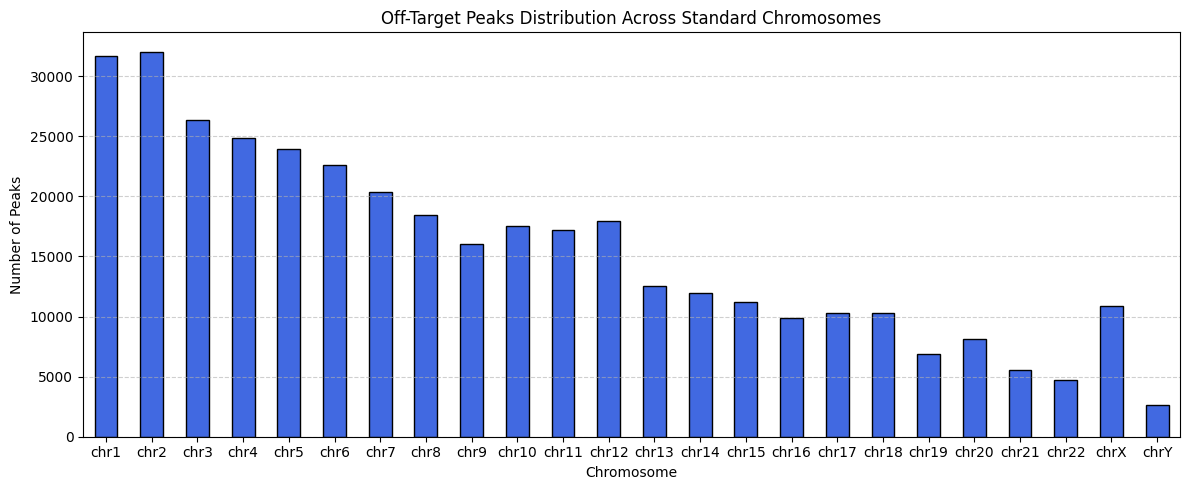

In [31]:
# Step 11: Genome wide off-target peaks visualization
import pandas as pd
import matplotlib.pyplot as plt

# Load your CSV
peaks_df = pd.read_csv("/content/guideseq/offtarget_peaks_only.csv")

# Keep standard chromosomes
standard_chroms = [f"chr{i}" for i in range(1, 23)] + ["chrX", "chrY"]
filtered = peaks_df[peaks_df["chr"].isin(standard_chroms)]

# Count peaks
chr_counts = filtered["chr"].value_counts().reindex(standard_chroms)

# Plot
plt.figure(figsize=(12, 5))
chr_counts.plot(kind="bar", color="royalblue", edgecolor="black")
plt.title("Off-Target Peaks Distribution Across Standard Chromosomes")
plt.xlabel("Chromosome")
plt.ylabel("Number of Peaks")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

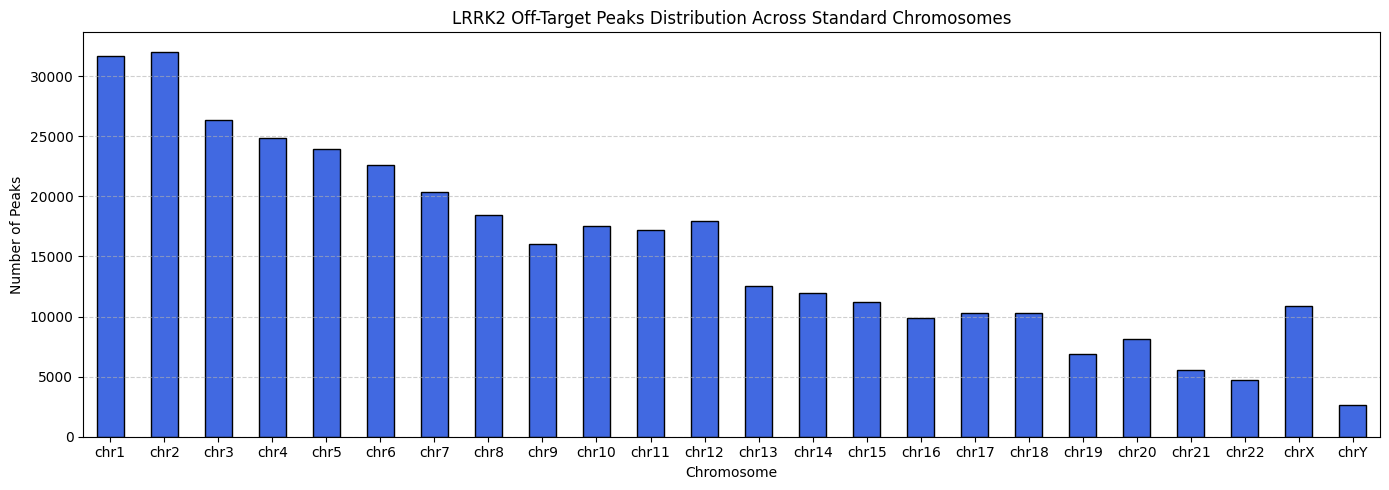

In [37]:
# Step 12: LRRK2 off_target visualizations
import pandas as pd
import matplotlib.pyplot as plt

# Load LRRK2 off-target peaks file
# Replace with your actual path if different
off_df = pd.read_csv("/content/guideseq/lrrk2_off_target.csv")

# Keep only standard chromosomes
standard_chroms = [f"chr{i}" for i in range(1, 23)] + ["chrX", "chrY"]
filtered_df = off_df[off_df["chr"].isin(standard_chroms)]

# Count number of peaks per chromosome
chr_counts = filtered_df["chr"].value_counts().reindex(standard_chroms).fillna(0)

# Plot
plt.figure(figsize=(14, 5))
chr_counts.plot(kind="bar", color="royalblue", edgecolor="black")
plt.title("LRRK2 Off-Target Peaks Distribution Across Standard Chromosomes")
plt.xlabel("Chromosome")
plt.ylabel("Number of Peaks")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()